# **Graph analysis**

## Imports

In [2]:
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
import numpy as np
import backboning_p3nx2.backboning as bb
import scipy.stats as stats
import powerlaw as pl
import forceatlas2

## Helper functions

In [3]:
def load_checkpoint(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

## Load data

In [4]:
G = pickle.load(open('graph_depth_2.pkl', 'rb'))

## Keep only the biggest connected component

In [5]:
print("Nodes before cleaning:", G.number_of_nodes())
G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
print("Nodes after cleaning:", G.number_of_nodes())

Nodes before cleaning: 824
Nodes after cleaning: 815


## Graph information and statistics

In [6]:
# Calculate metrics
nodes = list(G.nodes())
degrees = [G.degree(node) for node in nodes]
popularity = [G.nodes[node]['popularity'] for node in nodes]

In [7]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_nodes, num_edges

(815, 6259)

In [8]:
# top 10 nodes by degree
top_degree = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 performers by degree:")
for n, d in top_degree:
    print(f"{n}: {d}")

# top 10 most popular artists
node_content_popularity = [(node, G.nodes[node]['popularity']) for node in G.nodes()]
top_content_popularity = sorted(node_content_popularity, key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 performers by popularity:")
for n, p in top_content_popularity:
    print(f"{n}: {p} popularity")


Top 10 performers by degree:
Lil Wayne: 133
Future: 119
Ty Dolla $ign: 118
2 Chainz: 100
Kendrick Lamar: 97
Drake: 97
French Montana: 96
Young Thug: 94
Rick Ross: 94
Lil Baby: 89

Top 10 performers by popularity:
Taylor Swift: 100 popularity
Drake: 96 popularity
Bad Bunny: 96 popularity
The Weeknd: 94 popularity
Sabrina Carpenter: 92 popularity
Billie Eilish: 91 popularity
Justin Bieber: 91 popularity
Ariana Grande: 91 popularity
Rihanna: 91 popularity
Fuerza Regida: 90 popularity


The top 10 artists by degree is dominated by rappers, while the top 10 performers by popularity are more in line with the top 100 songs at the moment. This indicates that rappers have a tendency to do more featuring respect to other artists.

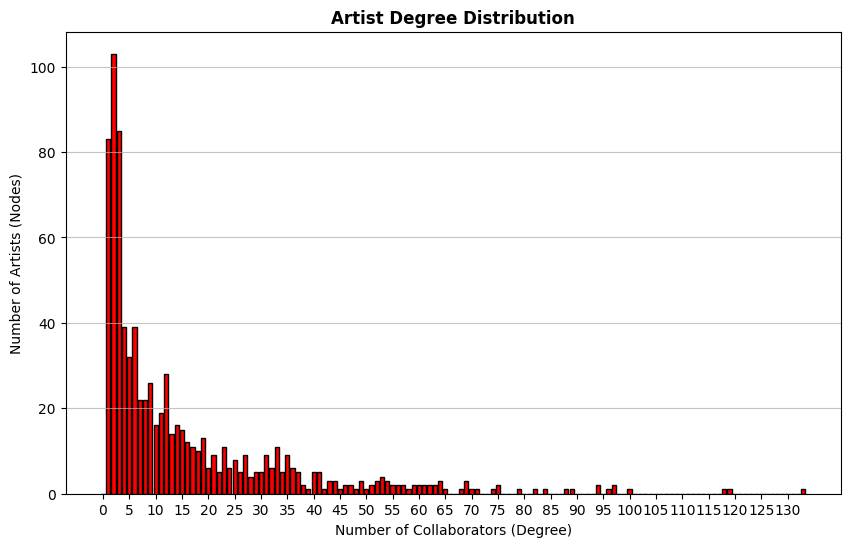

In [9]:
degree_counts = nx.degree_histogram(G)
degrees_range = range(len(degree_counts))

plt.figure(figsize=(10, 6))
plt.bar(degrees_range, degree_counts, color='red', edgecolor='black')
plt.title('Artist Degree Distribution', fontweight='bold')
plt.xlabel('Number of Collaborators (Degree)')
plt.ylabel('Number of Artists (Nodes)')
plt.xticks(range(0, len(degrees_range), 5))
plt.grid(axis='y', alpha=0.75)
plt.show()

The degree distribution histogram reveals a classic heavy-tailed distribution, typical of social networks. It also shows the presence of hubs (some artist exceed 100 collaborators). The network is probably a scale free network, which implies that the phenomenon of the "rich-get-richer" is taking place. This explains the artists with high degree, as famous artist tend to do more and more collaborations.

In [10]:
print("\nIn-Degree Statistics:")
print("Average:", np.mean(degrees))
print("Median:", np.median(degrees))
print("Mode:", stats.mode(degrees)[0])
print("Minimum:", np.min(degrees))
print("Maximum:", np.max(degrees))


In-Degree Statistics:
Average: 15.359509202453987
Median: 8.0
Mode: 2
Minimum: 1
Maximum: 133


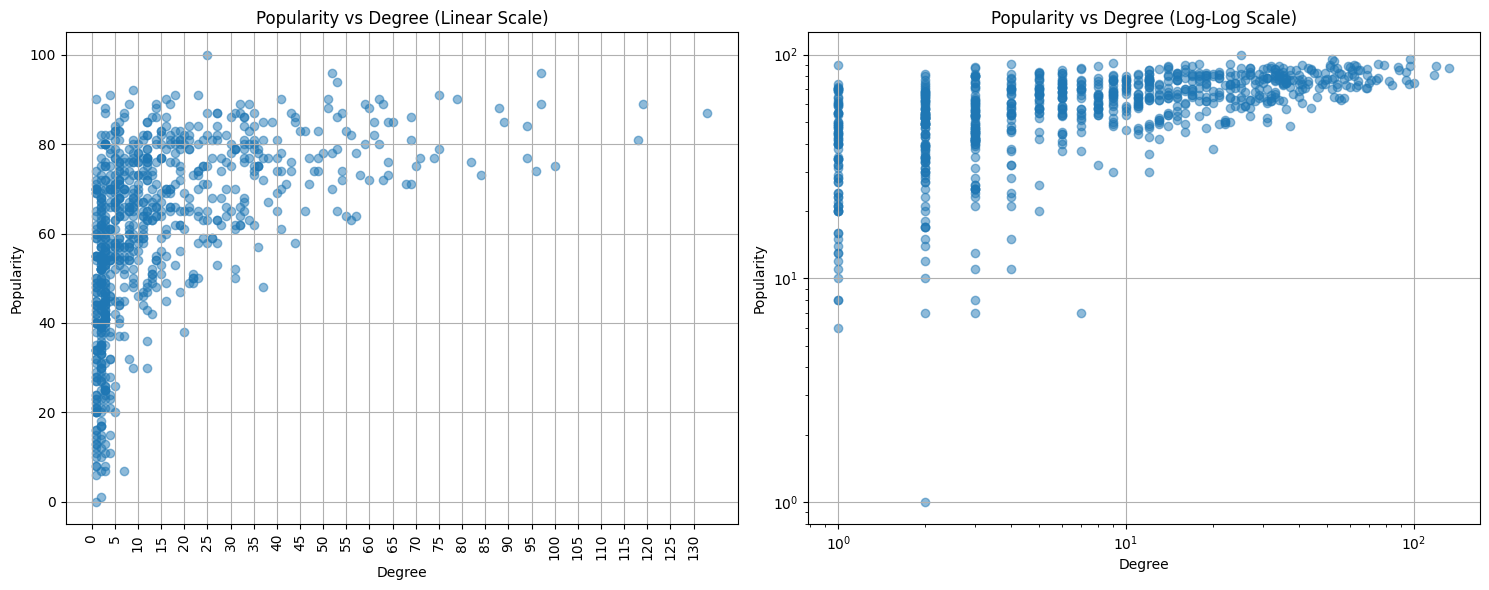

Spearman correlation between popularity and degree:
Correlation coefficient: 0.6418905922439765
P-value: 7.644703335190778e-96
------------------------------
The correlation between popularity and degree is statistically significant with significance level of 5%


In [11]:
# plot popularity vs degree
plt.figure(figsize=(15, 6))

# Linear Scale
plt.subplot(1, 2, 1)
plt.scatter(degrees, popularity, alpha=0.5)
plt.title('Popularity vs Degree (Linear Scale)')
plt.xlabel('Degree')
plt.ylabel('Popularity')
plt.grid(True)
plt.xticks(np.arange(0, max(degrees)+2, 5), rotation=90)

# Log-Log Scale
plt.subplot(1, 2, 2)
plt.scatter(degrees, popularity, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Popularity vs Degree (Log-Log Scale)')
plt.xlabel('Degree')
plt.ylabel('Popularity')
plt.grid(True)

plt.tight_layout()
plt.show()

# calculate Spearman correlation for word count vs out degree
corr_out, p_out = stats.spearmanr(popularity, degrees)
print(f"Spearman correlation between popularity and degree:")
print(f"Correlation coefficient: {corr_out}")
print(f"P-value: {p_out}")
print("-" * 30)

# p-value: 5% significance level
alpha = 0.05
if p_out < alpha:
    print("The correlation between popularity and degree is statistically significant with significance level of 5%")
else:
    print("The correlation between popularity and degree is not statistically significant with significance level of 5%")

There is a correlation between degree of each node and popularity, making the theory of the scale free network even stronger as this is another sign of the "rich-gets-richer" phenomenon. 

In [12]:
fit = pl.Fit(list(dict(G.degree()).values()))
print('Total degree exponent:', fit.alpha)

Calculating best minimal value for power law fit
Total degree exponent: 4.6748743862869215


The $\gamma$ value indicates that the network is not in the scale free regime but it's instead in the random network regime ($\gamma$ > 3 ) where both the first and second moments are finite (in scale free the variance is infinite allowing for mega-hubs). Networks of this type are difficult do distinguish form ar random network of similar size and they tend to converge to the small-world situation because for large $\gamma$ the degree distribution $p_k$ decays sufficiently fast to make the hubs small and less numerous.

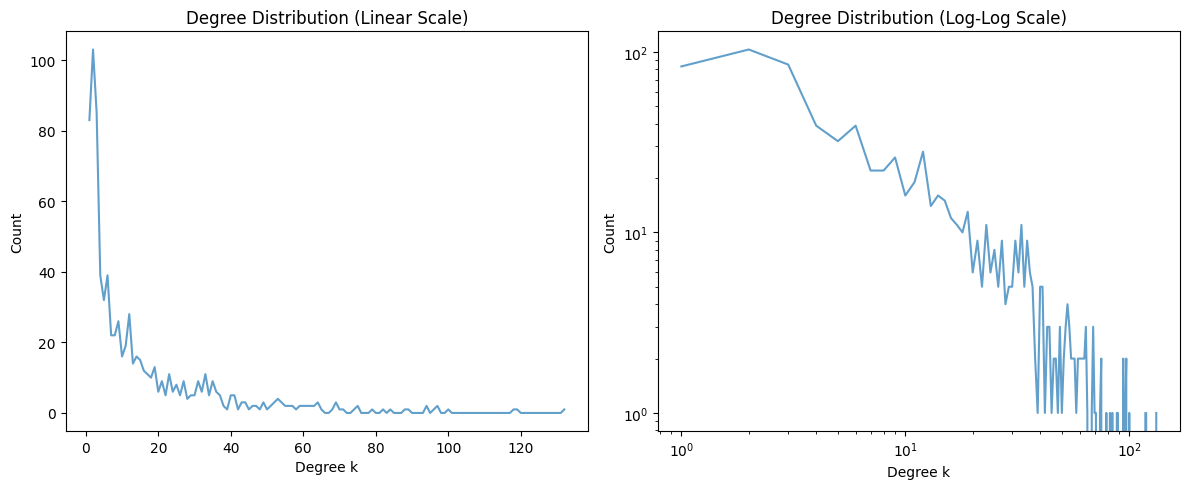

In [13]:
# bin the dirtubution with np.histgram and plot with linear and log-log axes
hist, bin_edges = np.histogram(list(dict(G.degree).values()), bins=range(1, max(dict(G.degree).values()) + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bin_edges[:-1], hist, alpha=0.7)
plt.xlabel('Degree k')
plt.ylabel('Count')
plt.title('Degree Distribution (Linear Scale)')

plt.subplot(1, 2, 2)
plt.plot(bin_edges[:-1], hist, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k')
plt.ylabel('Count')
plt.title('Degree Distribution (Log-Log Scale)')
plt.tight_layout()
plt.show()

From the linear scale plot we can see the skewness of the network. The sharp spike near zero shows that the vast majority of artists have very few collaborations, while the long tail to the right highlights the existence of hubs.

From the log-log Scale plot on the right, which is used as a tool for power-law distributions, we see a linear trend which supports the existence of a power-law-like mechanism. The slope of this line is steep, this corresponds to the high exponent ($\gamma \approx 4.67$) we calculated previously.

In [14]:
# 10 most central characters degree centrality
degree_centrality = nx.degree_centrality(G)
top_10_central = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most central characters by degree centrality:")
for character, centrality in top_10_central:
    print(f"{character}: {centrality:.4f}")

# 10 most central characters betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_10_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most central characters by betweenness centrality:")
for character, centrality in top_10_betweenness:
    print(f"{character}: {centrality:.4f}")


# 10 most central characters eigenvector centrality (in and out degree)
eigenvector_centrality = nx.eigenvector_centrality(G)
top_10_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most central characters by eigenvector centrality:")
for character, centrality in top_10_eigenvector_centrality:
    print(f"{character}: {centrality:.4f}")


Top 10 most central characters by degree centrality:
Lil Wayne: 0.1634
Future: 0.1462
Ty Dolla $ign: 0.1450
2 Chainz: 0.1229
Kendrick Lamar: 0.1192
Drake: 0.1192
French Montana: 0.1179
Young Thug: 0.1155
Rick Ross: 0.1155
Lil Baby: 0.1093

Top 10 most central characters by betweenness centrality:
David Guetta: 0.1235
Lady Gaga: 0.0643
KPop Demon Hunters Cast: 0.0621
Kendrick Lamar: 0.0579
Ed Sheeran: 0.0540
Lil Wayne: 0.0496
Fuerza Regida: 0.0491
Black Eyed Peas: 0.0451
Justin Bieber: 0.0450
Drake: 0.0407

Top 10 most central characters by eigenvector centrality:
Lil Wayne: 0.1817
2 Chainz: 0.1702
Future: 0.1698
Ty Dolla $ign: 0.1645
French Montana: 0.1546
Young Thug: 0.1498
Rick Ross: 0.1494
DJ Khaled: 0.1472
Chris Brown: 0.1465
T.I.: 0.1307


- Betweenness centrality = These artists are surely the most influential "powerful" artists in the network. They are situated in the majority of shortest paths connecting other nodes indicating their role as influential for the network
-  Eigenvector centrality = indicates that they are connected to other influential artists. Degree centrality is only about having many connections, eigenvector centrality also considers the quality of these connections. An artist with high betweenness centrality is a connection for different sub communities while an artist with high eigenvector centrality is at the center of a dense community, surrounded by other influential artists.  

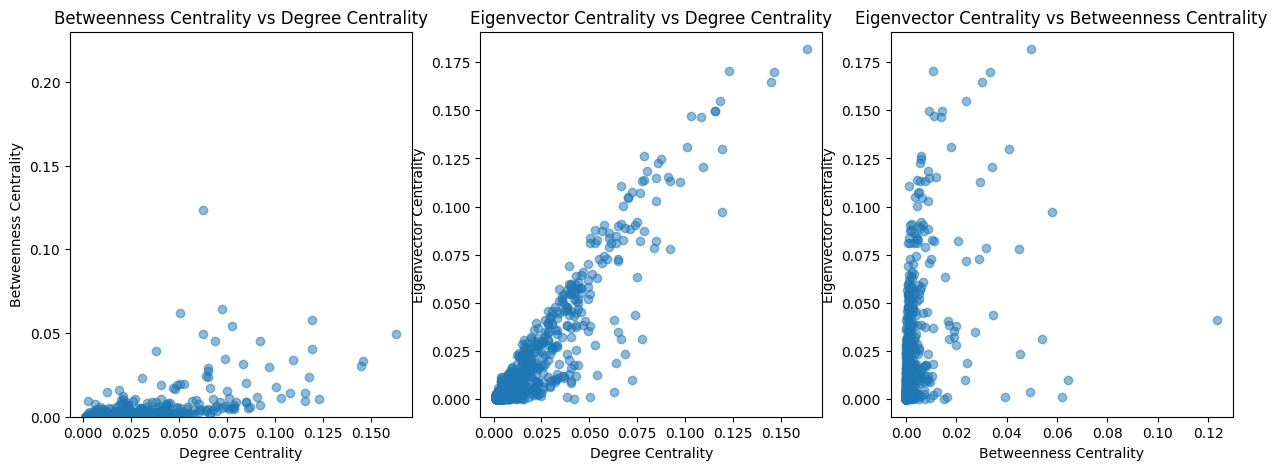

In [15]:
# betweenness centrality vs degree centrality, degree centrality vs eigenvector centrality, and 
# betweenness centrality vs eigenvector centrality
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(list(degree_centrality.values()), list(betweenness_centrality.values()), alpha=0.5)
plt.ylim(0, 0.23)
plt.xlabel('Degree Centrality')
plt.ylabel('Betweenness Centrality')
plt.title('Betweenness Centrality vs Degree Centrality')

plt.subplot(1, 3, 2)
plt.scatter(list(degree_centrality.values()), list(eigenvector_centrality.values()), alpha=0.5)
plt.xlabel('Degree Centrality')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality vs Degree Centrality')

plt.subplot(1, 3, 3)
plt.scatter(list(betweenness_centrality.values()), list(eigenvector_centrality.values()), alpha=0.5)
plt.xlabel('Betweenness Centrality')
plt.ylabel('Eigenvector Centrality')
plt.title('Eigenvector Centrality vs Betweenness Centrality')
plt.axes
plt.show()

The left plot shows a weak correlation between betweenness centrality and degree centrality, this can be explained by the nodes with increasing degree have many more links and act as hubs connecting other nodes during the respective shortest path walks. At the same time the relation in not that strong as many nodes have medium/high degree but low betweenness.

The correlation between eigenvector centrality and degree centrality indicates a clear tendency that describes how having more links increases the change of being connected to other important nodes resulting in hight eigenvector centrality. 

In [16]:
# degree assortativity for the graph
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity coefficient: {degree_assortativity:.4f}")

# attribute assortativity for 'popularity'
attribute_assortativity = nx.attribute_assortativity_coefficient(G, 'popularity')
print(f"Attribute assortativity for 'popularity': {attribute_assortativity:.4f}")

Degree assortativity coefficient: 0.0747
Attribute assortativity for 'popularity': 0.0029


The degree and attribute assortativities are close to 0 indicating that there is not a real and strong tendency for nodes with high degree to link to other high degree nodes and popular nodes to link with other popular nodes. If we look at each individual value we can see that a slightly more tendency is calculated for the degree assortativity, but it still remains far from the max value of 1.

Artist Network:
Average Shortest Path Length: 3.1865

Random Network:
Average Shortest Path Length: 2.7412


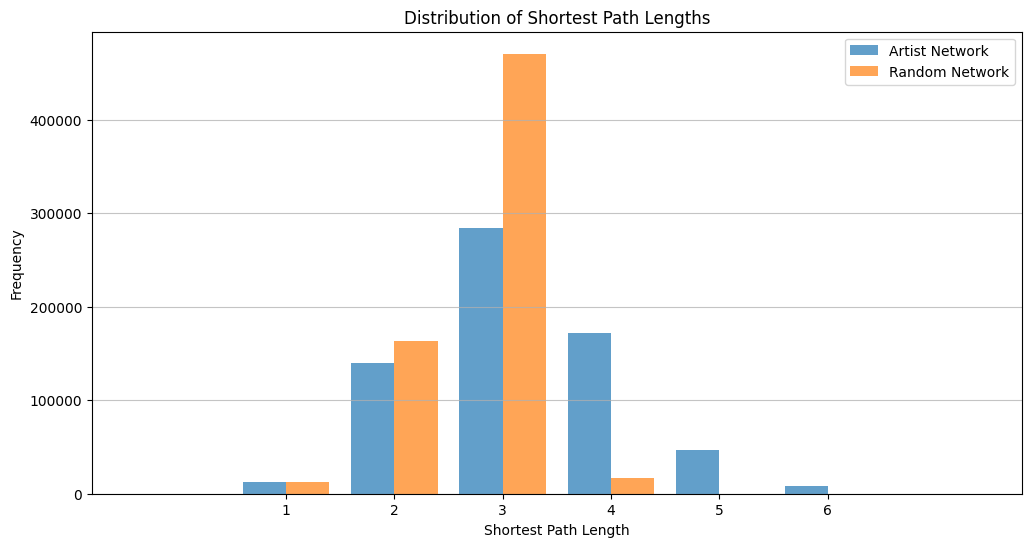

In [17]:
# average shortest path length vs a random graph
N = G.number_of_nodes()
L = G.number_of_edges()

avg_shortest_path_real = nx.average_shortest_path_length(G)
print(f"Artist Network:")
print(f"Average Shortest Path Length: {avg_shortest_path_real:.4f}")

# random Erdos-Renyi graph with the same number of nodes and edges
ER = nx.gnm_random_graph(N, L)
if not nx.is_connected(ER):
    largest_cc_random = max(nx.connected_components(ER), key=len)
    ER_conn = ER.subgraph(largest_cc_random).copy()
else:
    ER_conn = ER.copy()

avg_shortest_path_random = nx.average_shortest_path_length(ER_conn)
print(f"\nRandom Network:")
print(f"Average Shortest Path Length: {avg_shortest_path_random:.4f}")

paths_real = [l for l_dict in dict(nx.all_pairs_shortest_path_length(G)).values() for l in l_dict.values() if l > 0]
paths_random = [l for l_dict in dict(nx.all_pairs_shortest_path_length(ER_conn)).values() for l in l_dict.values() if l > 0]

# plot
max_len = max(max(paths_real), max(paths_random))
bins = np.arange(max_len + 2) - 0.5
hist_real, bin_edges_real = np.histogram(paths_real, bins=bins)
hist_random, bin_edges_random = np.histogram(paths_random, bins=bins)
plt.figure(figsize=(12, 6))
width = 0.4
bin_centers = bin_edges_real[:-1] + 0.5
plt.bar(bin_centers - width/2, hist_real, width=width, alpha=0.7, label='Artist Network')
plt.bar(bin_centers + width/2, hist_random, width=width, alpha=0.7, label='Random Network')
plt.title('Distribution of Shortest Path Lengths')
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(np.arange(1, max_len))
plt.grid(axis='y', alpha=0.75)
plt.show()

The two averages shortest path lengths are similar for the artist network and the random graph with the same number of nodes $N$ and probability of connection $p$. In particular from the distribution plot I see that the random network, in orange, is slightly better connected, having it's distribution a bit shifted to the left towards lengths of paths of 1 and 2 and 3, while the real network has also some values with shortest path length of 4, 5 and 6.

## Plotting

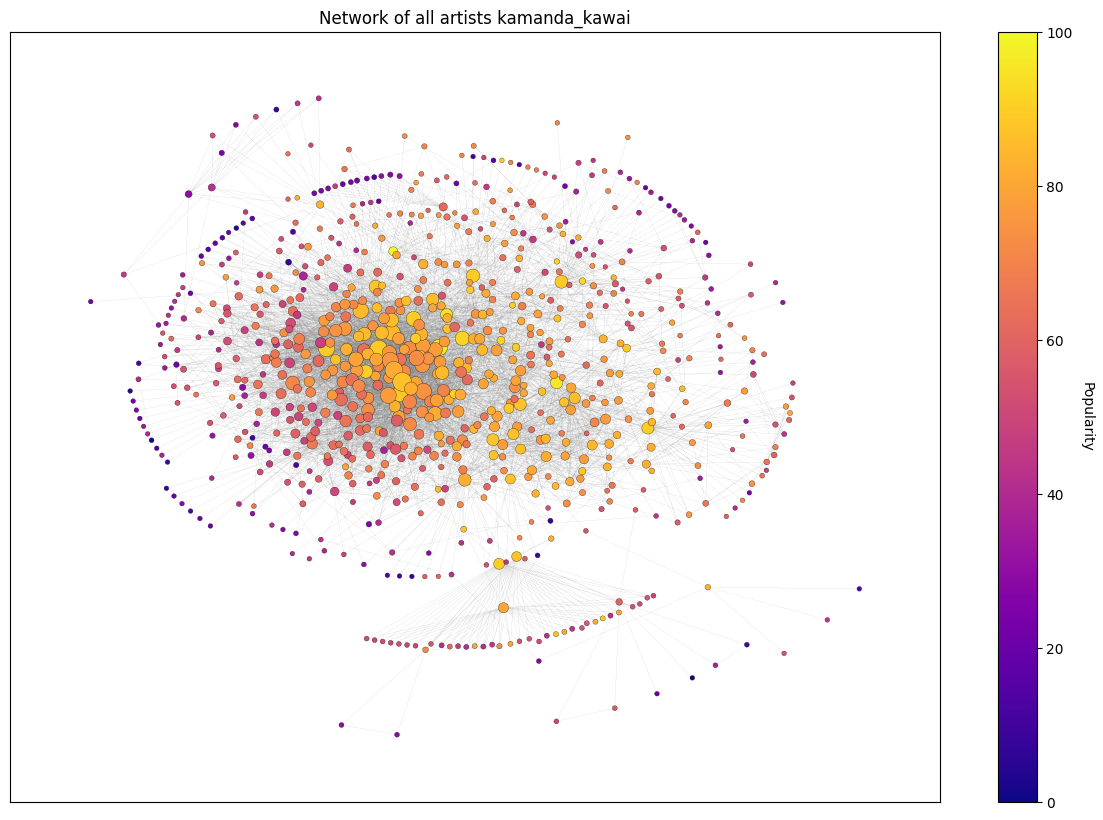

In [18]:
# kamnada_kawai layout
plt.figure(figsize=(15, 10))
plt.title("Network of all artists kamanda_kawai")
pos = nx.kamada_kawai_layout(G)
node_sizes = [10 + (d * 1.3) for d in degrees]
nodes_drawn = nx.draw_networkx_nodes(G, pos,
                                     nodelist=nodes,
                                     node_size=node_sizes,
                                     node_color=popularity,
                                     cmap=plt.cm.plasma,
                                     edgecolors='black',
                                     linewidths=0.2)

nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.6, edge_color='gray')
cbar = plt.colorbar(nodes_drawn)
cbar.set_label('Popularity', rotation=270, labelpad=15)
plt.show()

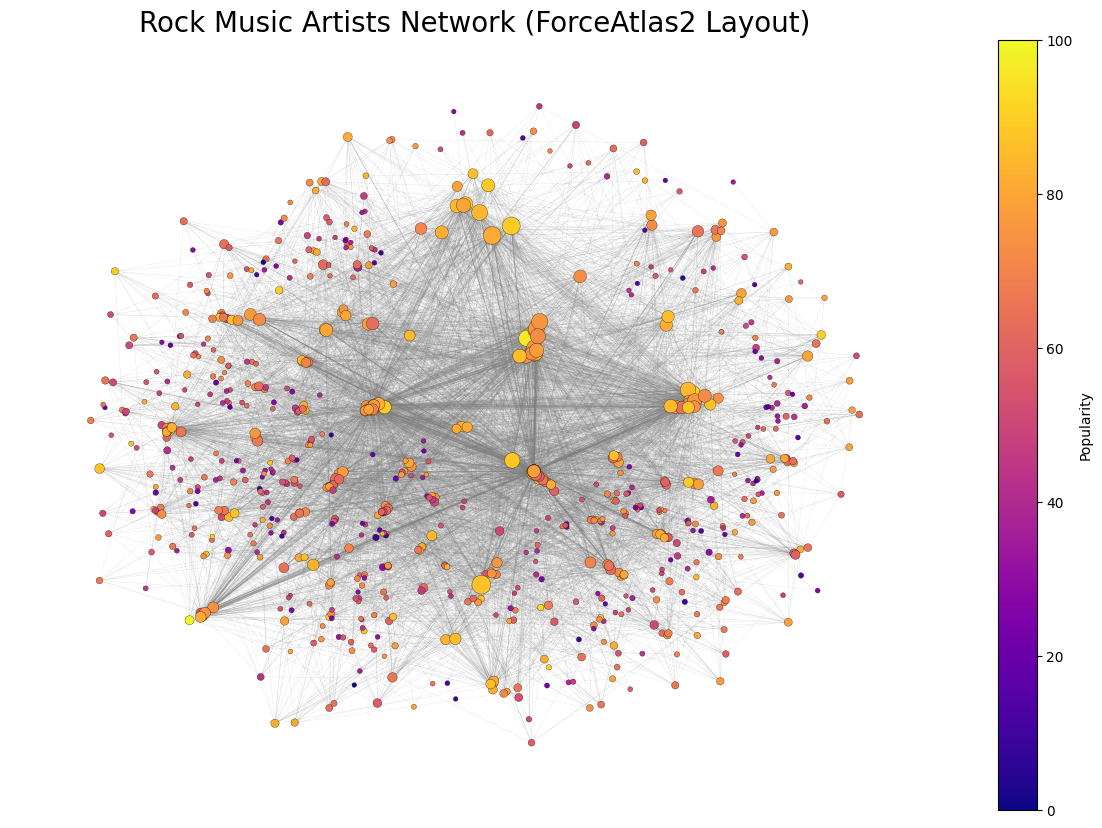

In [19]:
node_sizes_dic = {node: 10 + (G.degree(node) * 1.3) for node in G.nodes()}
pos = nx.forceatlas2_layout(G, node_size=node_sizes_dic, distributed_action=True, dissuade_hubs=True)

plt.figure(figsize=(15, 10))
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=popularity,
    cmap=plt.cm.plasma,
    edgecolors='black',
    linewidths=0.2
)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.6, edge_color='gray')
plt.title("Rock Music Artists Network (ForceAtlas2 Layout)", fontsize=20)
cbar = plt.colorbar(nodes)
cbar.set_label("Popularity")
plt.axis('off')
plt.show()

### Testing Plotly graph

In [20]:
import plotly.graph_objects as go

node_sizes_dic = {node: 3 + (G.degree(node) * 0.2) for node in G.nodes()}
pos = nx.forceatlas2_layout(G, node_size=node_sizes_dic, gravity=2, distributed_action=True)

# 1. Create Edge Trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.2, color='rgba(150, 150, 150, 0.3)'),
    hoverinfo='none',
    mode='lines',
    )

# 2. Create Node Trace
node_x = []
node_y = []
node_text = []
node_sizes_list = []
node_colors_list = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Data for styling and hover
    pop = G.nodes[node]['popularity']
    deg = G.degree(node)
    
    node_text.append(f"Artist: {node}<br>Popularity: {pop}<br>Degree: {deg}")
    node_colors_list.append(pop)
    node_sizes_list.append(3 + (deg * 0.2))

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=True,
        colorscale='Plasma', # Matches plt.cm.plasma
        color=node_colors_list,
        size=node_sizes_list,
        colorbar=dict(
            thickness=15,
            title=dict(
                text='Popularity',
                side='right'
            ),
            xanchor='left'
        ),
        line_width=1, # Edge border width
        line_color='black' # Edge border color
    )
)

# 3. Create Figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=dict(
                    text='Rock Music Artists Network (ForceAtlas2 Layout)',
                    font=dict(size=20)
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                width=1000,
                height=800
             ))

fig.show()

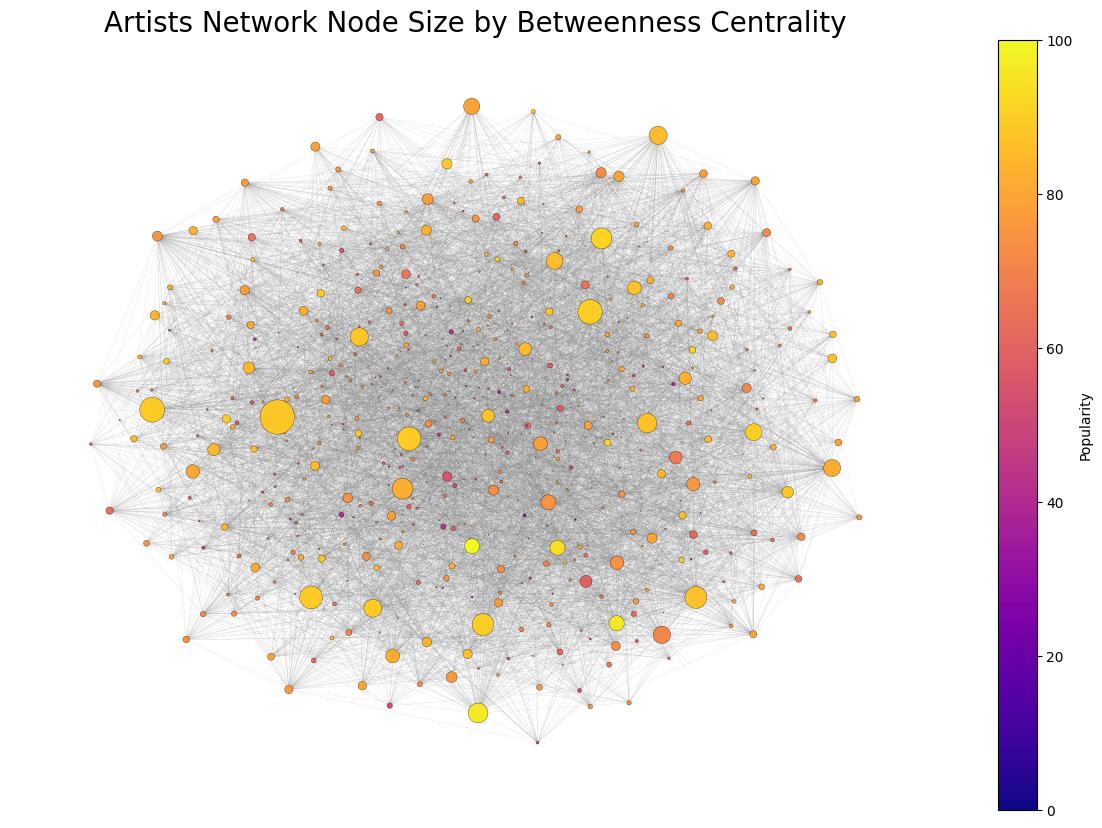

In [21]:
# node size depends on betweenness centrality
node_sizes = [d * 5000 for d in betweenness_centrality.values()]
plt.figure(figsize=(15, 10))
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=popularity,
    cmap=plt.cm.plasma,
    edgecolors='black',
    linewidths=0.2
)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.6, edge_color='gray')
plt.title("Artists Network Node Size by Betweenness Centrality", fontsize=20)
cbar = plt.colorbar(nodes)
cbar.set_label("Popularity")
plt.axis('off')
plt.show()

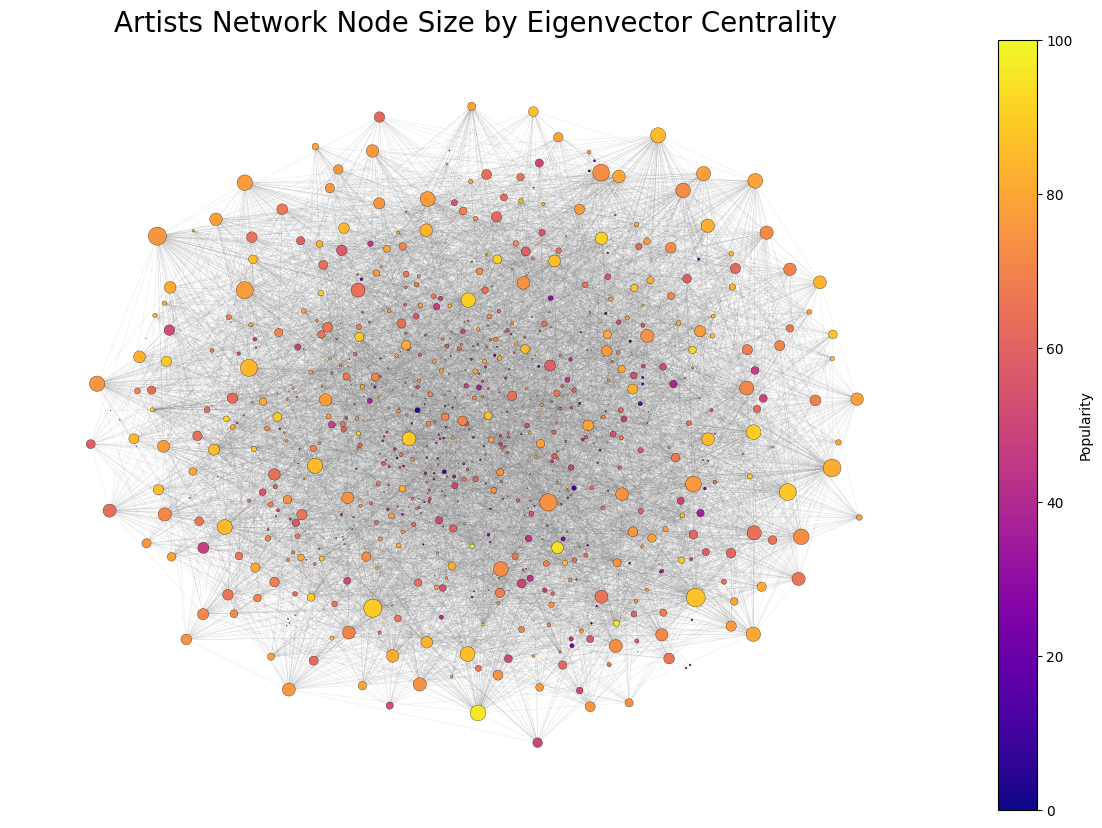

In [22]:
# node size depends on in edge eigenvector centrality
node_sizes = [d * 1000 for d in eigenvector_centrality.values()]
plt.figure(figsize=(15, 10))
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_sizes,
    node_color=popularity,
    cmap=plt.cm.plasma,
    edgecolors='black',
    linewidths=0.2
)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.6, edge_color='gray')
plt.title("Artists Network Node Size by Eigenvector Centrality", fontsize=20)
cbar = plt.colorbar(nodes)
cbar.set_label("Popularity")
plt.axis('off')
plt.show()

Calculating DF score...
Calculating DF score...
Calculating HSS score...


Backbone 1 (Disparity Filter on High Betweenness): 326 nodes, 250 edges
Backbone 2 (Disparity Filter on Low Betweenness): 438 nodes, 420 edges
Backbone 3 (High-Salience Skeleton): 278 nodes, 250 edges


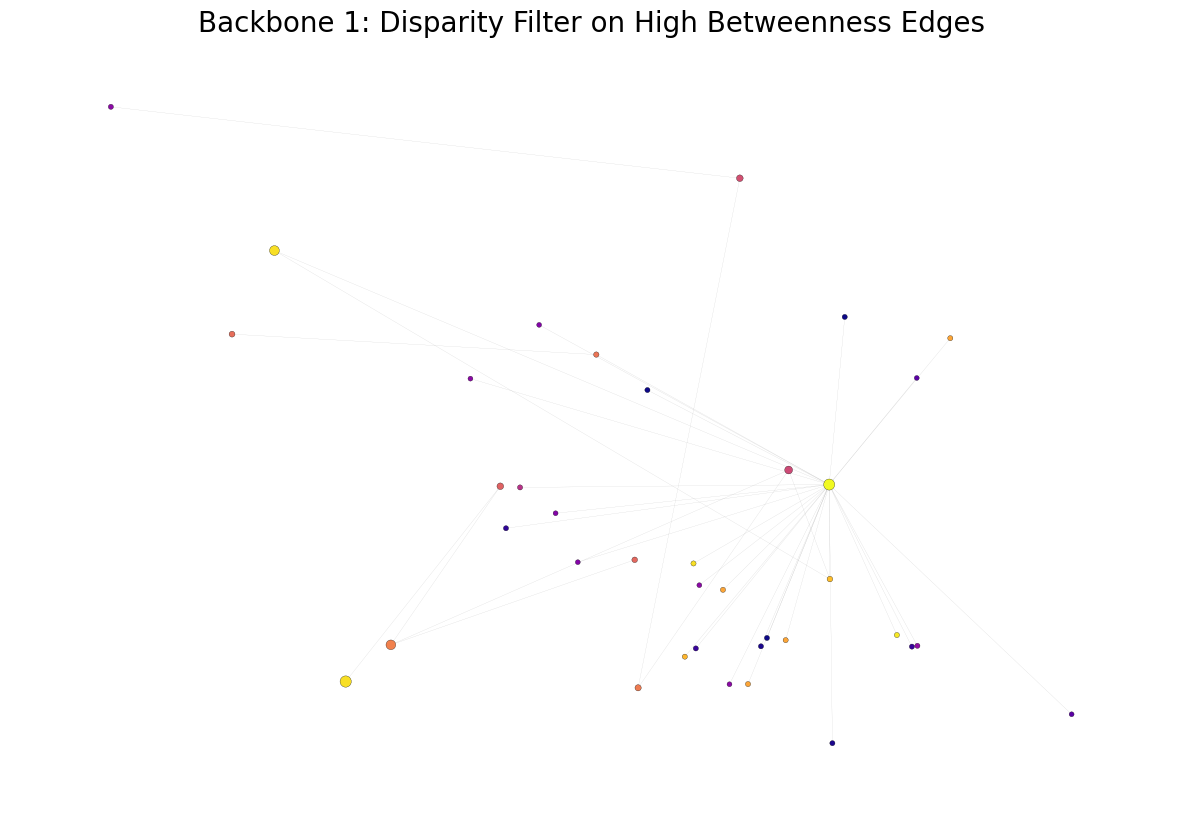

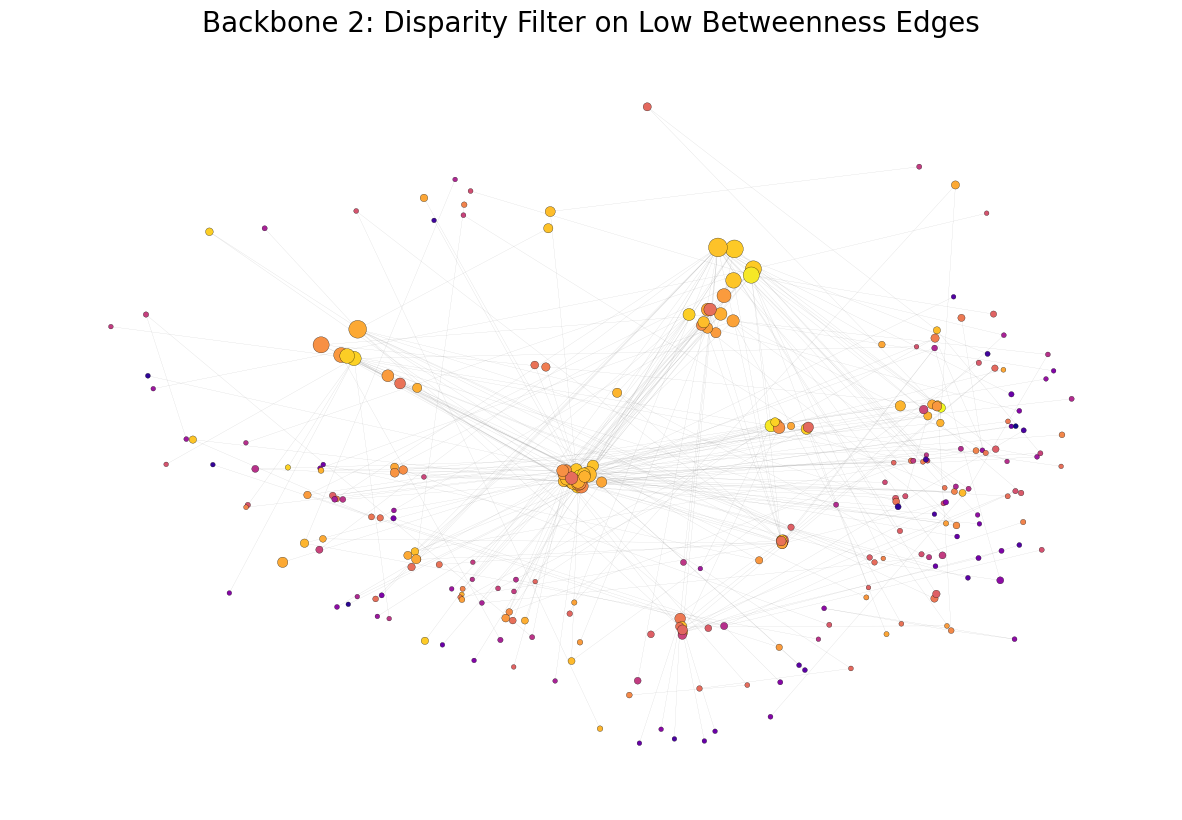

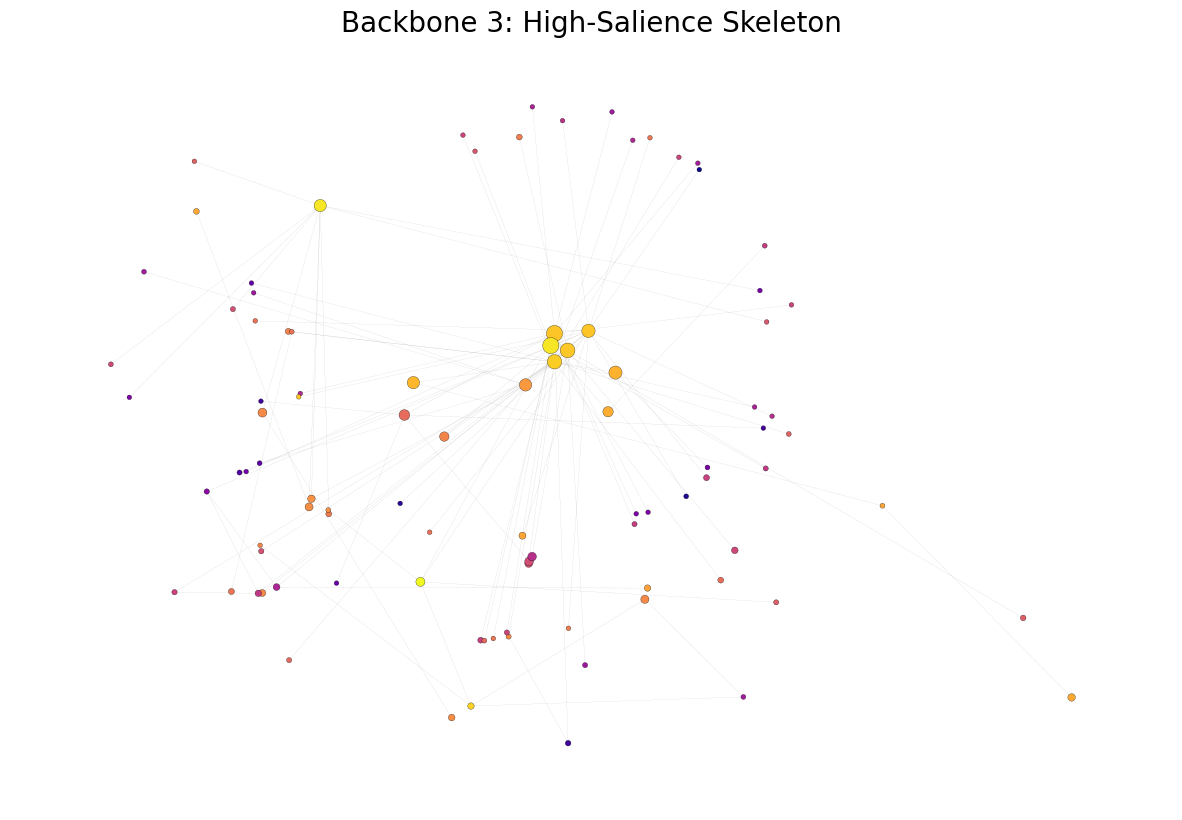

In [23]:
edge_betweenness = nx.edge_betweenness_centrality(G)

# weighted network 1
G_w1 = G.copy()

# scale in range [1, 100]
eb_values = list(edge_betweenness.values())
min_val = min(eb_values)
max_val = max(eb_values)
val_range = max_val - min_val
new_min = 1
new_max = 100
new_range = new_max - new_min
scaled_weights = [((x - min_val) / val_range) * new_range + new_min for x in eb_values]

for i, edge in enumerate(edge_betweenness.keys()):
    G_w1.edges[edge]['weight'] = scaled_weights[i]

# weighted network 2
G_w2 = G.copy()
for i, edge in enumerate(edge_betweenness.keys()):
    G_w2.edges[edge]['weight'] = 1 / scaled_weights[i]

# extract backbones 
# library expects columns 'src', 'trg', and 'nij' (weight)
table_w1 = nx.to_pandas_edgelist(G_w1, source='src', target='trg')
table_w1.rename(columns={'weight': 'nij'}, inplace=True)

table_w2 = nx.to_pandas_edgelist(G_w2, source='src', target='trg')
table_w2.rename(columns={'weight': 'nij'}, inplace=True)

# weighted network 3
G_undirected_w = G.copy()
nx.set_edge_attributes(G_undirected_w, 1, 'weight')
table_undirected = nx.to_pandas_edgelist(G_undirected_w, source='src', target='trg')
table_undirected.rename(columns={'weight': 'nij'}, inplace=True)

# the alpha parameter for the first two backbones 
alpha = 0.4

# backbone network 1 
df_backbone1 = bb.disparity_filter(table_w1, undirected=True)
backbone_1_table = df_backbone1[df_backbone1['score'] < alpha]
backbone_1 = nx.from_pandas_edgelist(backbone_1_table, 'src', 'trg', create_using=nx.Graph())
print(f"Backbone 1 (Disparity Filter on High Betweenness): {backbone_1.number_of_nodes()} nodes, {backbone_1.number_of_edges()} edges")

# backbone network 2
df_backbone2 = bb.disparity_filter(table_w2, undirected=True)
backbone_2_table = df_backbone2[df_backbone2['score'] < alpha]
backbone_2 = nx.from_pandas_edgelist(backbone_2_table, 'src', 'trg', create_using=nx.Graph())
print(f"Backbone 2 (Disparity Filter on Low Betweenness): {backbone_2.number_of_nodes()} nodes, {backbone_2.number_of_edges()} edges")

# backbone network 3
# identifies the most 'salient' paths in the network
df_backbone3 = bb.high_salience_skeleton(table_undirected, undirected=True)
top_n_edges = backbone_1.number_of_edges()
backbone_3_table = df_backbone3.nlargest(top_n_edges, 'score')
backbone_3 = nx.from_pandas_edgelist(backbone_3_table, 'src', 'trg', create_using=nx.Graph())
print(f"Backbone 3 (High-Salience Skeleton): {backbone_3.number_of_nodes()} nodes, {backbone_3.number_of_edges()} edges")


# plot the backbones
original_degrees = dict(G.degree())

def plot_backbone(graph, title, original_degrees_dict):    
    if not nx.is_connected(graph):
        largest_cc = max(nx.connected_components(graph), key=len)
        plot_graph = graph.subgraph(largest_cc)
    else:
        plot_graph = graph


    # CHOOSE EITHER ALGORITHM
    # 1
    # Manually call the core forceatlas2 function to avoid the deprecated wrapper
    node_sizes_dic = {node: 10 + original_degrees_dict[node] * 1.3 for node in plot_graph.nodes()}
    pos_backbone = nx.forceatlas2_layout(G, node_size=node_sizes_dic, gravity=0.1)
    # 2
    # pos_array = forceatlas2.forceatlas2(nx.to_numpy_array(plot_graph), gravity=0.1)
    # pos_backbone = {node: pos_array[i] for i, node in enumerate(plot_graph.nodes())}

    node_sizes = [10 + original_degrees_dict[node] * 1.3 for node in plot_graph.nodes()]
    popularity = [G.nodes[node]['popularity'] for node in plot_graph.nodes()]

    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(
        plot_graph,
        pos_backbone,
        node_size=node_sizes,
        node_color=popularity,
        cmap=plt.cm.plasma,
        edgecolors='black',
        linewidths=0.2
    )
    nx.draw_networkx_edges(plot_graph, pos_backbone,  width=0.1, alpha=0.6, edge_color='gray')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

plot_backbone(backbone_1, "Backbone 1: Disparity Filter on High Betweenness Edges", original_degrees)
plot_backbone(backbone_2, "Backbone 2: Disparity Filter on Low Betweenness Edges", original_degrees)
plot_backbone(backbone_3, "Backbone 3: High-Salience Skeleton", original_degrees)

Backbone 1 is constructed on the high betweenness edges and it highlights those particular links that connect two distinct clusters of nodes stripping away most of the others. It highlights the most important inter long range connections indicating the nodes that are fundamental to interconnect the whole network and its different hubs. Backbone 2 is the inverse of the first one, and this is given by the mathematical formula we used to calculate the weights which is 1/(edge weight in Weighted Network 1). It shows the connections in each community and the intra (local connections) community structure. Backbone 3 can be seen as a middle view of backbone 1 and 2. Some long connection between different clusters have been preserved but also local connections within similar artists are present. It highlights the edges that are the most important for moving through the graph.

## Communities and Popularity

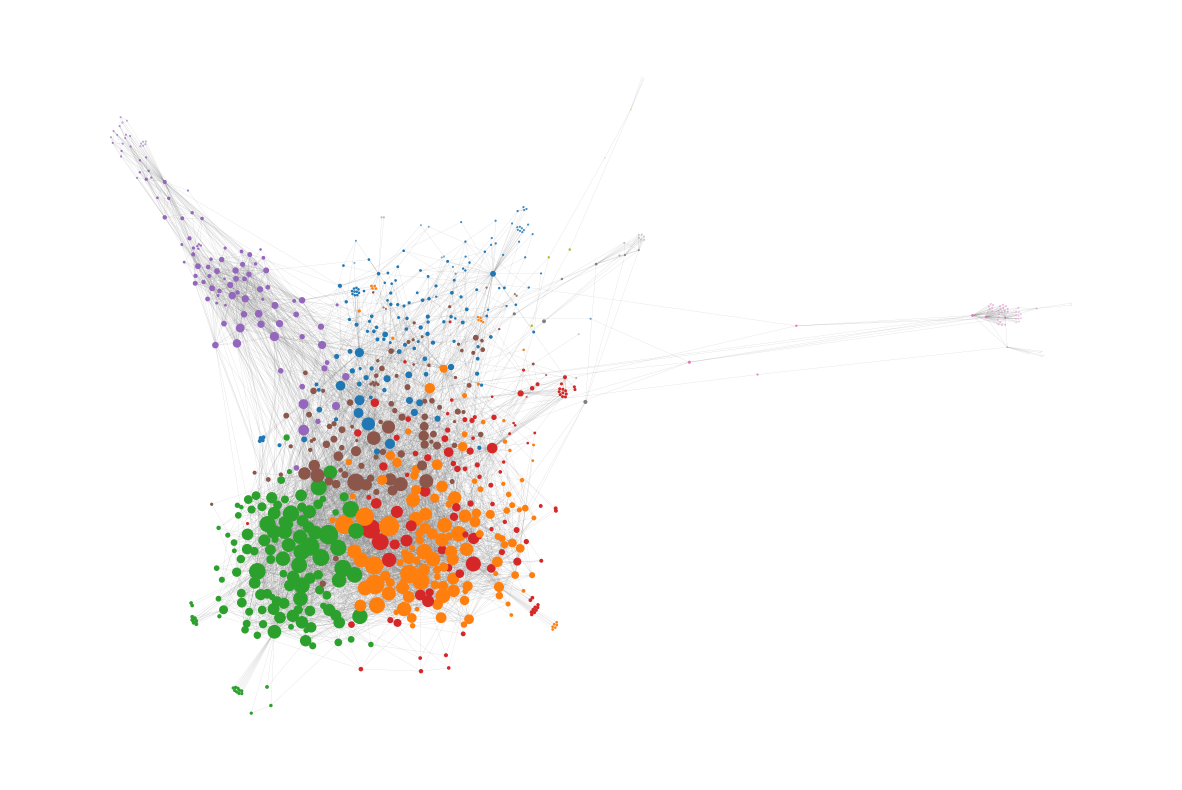

In [180]:
pos_array = forceatlas2.forceatlas2(nx.to_numpy_array(G))
pos_subgraph = {node: pos_array[i] for i, node in enumerate(G.nodes())}

sorted_communities = sorted(nx_comm.louvain_communities(G), key=len, reverse=True)
top_n = len(sorted_communities)

node_to_community = {}
for i, comm in enumerate(sorted_communities):
    for node in comm:
        node_to_community[node] = i


top_n += 1
cmap = plt.colormaps.get_cmap('tab10')
colors = [cmap(i / top_n) for i in range(top_n)]

node_colors = []
for node in G.nodes():
    community_index = node_to_community.get(node, -1)
    if community_index != -1 and community_index <= top_n:
        node_colors.append(colors[community_index])
    else:
        node_colors.append('lightgray')

plt.figure(figsize=(15, 10))
nx.draw_networkx_edges(G, pos_subgraph, width=0.1, alpha=0.6, edge_color='gray')
nx.draw_networkx_nodes(G, pos_subgraph, node_color=node_colors, node_size=node_sizes)

plt.axis('off')
plt.show()

In [25]:
nx.set_node_attributes(G, node_to_community, 'community')

In [26]:
pickle.dump(G, open('graph_with_communities.pkl', 'wb'))

In [43]:
import pandas as pd
from collections import Counter

rows = []
for n in G.nodes():
    c = node_to_community.get(n, -1)
    pop = G.nodes[n].get('popularity', np.nan)
    deg = G.degree(n)
    clust = nx.clustering(G, n)
    genre = G.nodes[n].get('genres', 'Unknown')
    rows.append({'node': n, 'community': c, 'popularity': pop, 'degree': deg, 'clustering': clust, 'genre': genre})
df = pd.DataFrame(rows)

comm_stats = df.groupby('community').agg(
    size=('node','count'),
    pop_mean=('popularity','mean'),
    pop_median=('popularity','median'),
    pop_std=('popularity','std'),
    deg_mean=('degree','mean'),
    deg_median=('degree','median'),
    deg_std=('degree','std'),
    clust_mean=('clustering','mean')
).sort_values('size', ascending=False)

comm_stats


size   pop_mean  pop_median    pop_std   deg_mean  deg_median  \
community                                                                  
0           166  64.096386        67.0  16.480743   8.289157         5.0   
1           156  57.660256        63.0  21.416755  21.429487        14.0   
2           154  64.402597        66.0  16.718163  29.012987        23.0   
3           128  68.039062        75.5  18.968437  13.890625         9.5   
4            96  53.947917        56.5  18.681468  10.510417         5.0   
5            50  55.860000        53.0  20.128171   4.740000         2.5   
6            42  50.404762        46.5  18.844757   4.976190         3.0   
7            15  45.266667        42.0  20.204196   5.400000         3.0   
8             8  45.625000        43.5  20.742899   2.125000         2.0   

             deg_std  clust_mean  
community                         
0          10.960569    0.224822  
1          21.830760    0.349202  
2          25.462002    0.299362  
3          13.255951    0.420900  
4          14.003755    0.365300  
5           8.014808    0.826225  
6           9.153136    0.414435  
7           4.272838    0.587415  
8           1.356203    0.000000

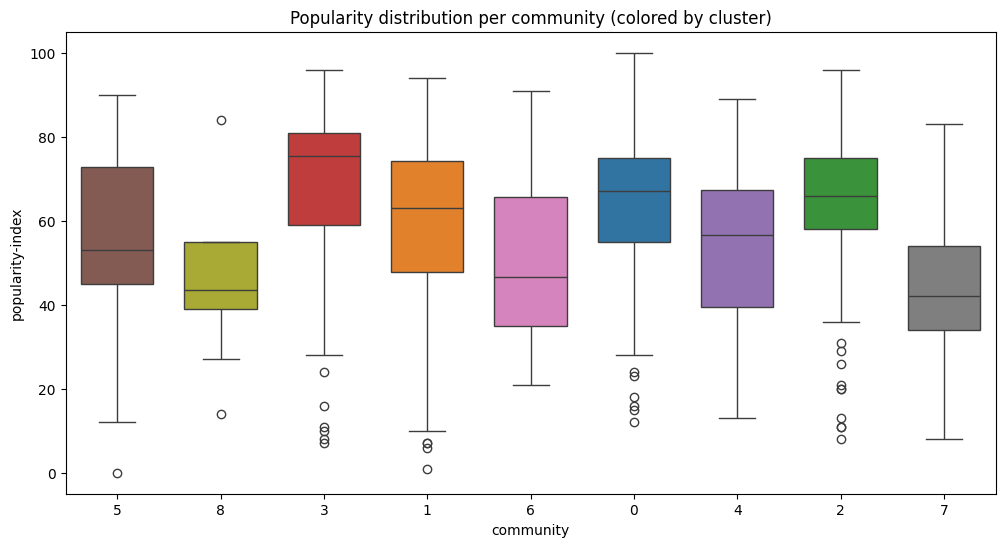

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = df[df['community'].isin(range(len(sorted_communities)))].copy()

plot_df['community'] = plot_df['community'].astype(int)

community_color_map = {str(i): colors[i] for i in range(len(sorted_communities))}

plot_df['community_str'] = plot_df['community'].astype(str)

plt.figure(figsize=(12,6))

sns.boxplot(
    data=plot_df,
    x='community_str',
    y='popularity',
    hue='community_str',
    palette=community_color_map,
    legend=False,
    width=0.7
)

plt.xlabel('community')
plt.ylabel('popularity-index')
plt.title('Popularity distribution per community (colored by cluster)')
plt.show()


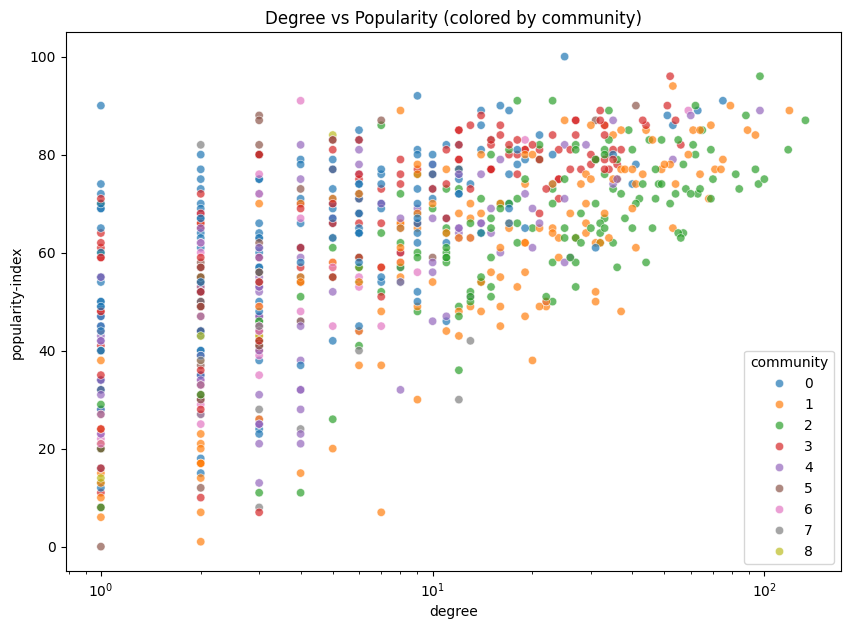

In [29]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='degree', y='popularity', hue='community', palette='tab10', alpha=0.7)
plt.xlabel('degree')
plt.ylabel('popularity-index')
plt.title('Degree vs Popularity (colored by community)')
plt.xscale('log')
plt.show()


In [30]:
from scipy.stats import spearmanr, pearsonr

# global
pearson_global = pearsonr(df['degree'], df['popularity'])
spearman_global = spearmanr(df['degree'], df['popularity'])

# per community
per_comm_corr = {}
for c, g in df.groupby('community'):
    if len(g) >= 5:
        per_comm_corr[c] = {
            'pearson_r': pearsonr(g['degree'], g['popularity'])[0],
            'spearman_r': spearmanr(g['degree'], g['popularity']).correlation,
            'n': len(g)
        }
pd.DataFrame.from_dict(per_comm_corr, orient='index').sort_values('n', ascending=False)


pearson_r  spearman_r    n
0   0.467848    0.606887  166
1   0.633009    0.740204  156
2   0.568554    0.678638  154
3   0.618929    0.797532  128
4   0.572790    0.689762   96
5   0.448608    0.569330   50
6   0.472199    0.554843   42
7   0.208835    0.069417   15
8   0.692537    0.291349    8

In [31]:
from scipy.stats import kruskal

groups = [group['popularity'].dropna().values for _, group in df.groupby('community') if len(group)>=5]
stat, pval = kruskal(*groups)
stat, pval


(np.float64(81.8380161254341), np.float64(2.0841785755126474e-14))

In [189]:
import scikit_posthocs as sp_post

filtered = df.dropna(subset=['popularity']).copy()
filtered = filtered.groupby('community').filter(lambda g: len(g) >= 5)

# --- Pairwise Dunn test ---
pairwise = sp_post.posthoc_dunn(
    filtered,
    val_col='popularity',
    group_col='community',
    p_adjust='fdr_bh'
)

pairwise


0         1         2             3             4         5  \
0  1.000000  0.028413  0.816299  1.864211e-02  2.005375e-04  0.018980   
1  0.028413  1.000000  0.019510  1.131953e-05  8.287749e-02  0.378761   
2  0.816299  0.019510  1.000000  2.841280e-02  1.237590e-04  0.013628   
3  0.018642  0.000011  0.028413  1.000000e+00  2.161382e-08  0.000058   
4  0.000201  0.082877  0.000124  2.161382e-08  1.000000e+00  0.646158   
5  0.018980  0.378761  0.013628  5.817086e-05  6.461585e-01  1.000000   
6  0.000196  0.023844  0.000124  1.641553e-07  3.774740e-01  0.246462   
7  0.002427  0.029100  0.001866  5.817086e-05  2.222053e-01  0.147153   
8  0.023959  0.120648  0.021544  2.482304e-03  3.704016e-01  0.273931   

              6         7         8  
0  1.962918e-04  0.002427  0.023959  
1  2.384447e-02  0.029100  0.120648  
2  1.237590e-04  0.001866  0.021544  
3  1.641553e-07  0.000058  0.002482  
4  3.774740e-01  0.222205  0.370402  
5  2.464621e-01  0.147153  0.273931  
6  1.000000e+00  0.560803  0.646158  
7  5.608025e-01  1.000000  0.987289  
8  6.461585e-01  0.987289  1.000000

Text(0.5, 1.0, 'Pairwise Dunn-test of differences in Popularity between Communities')

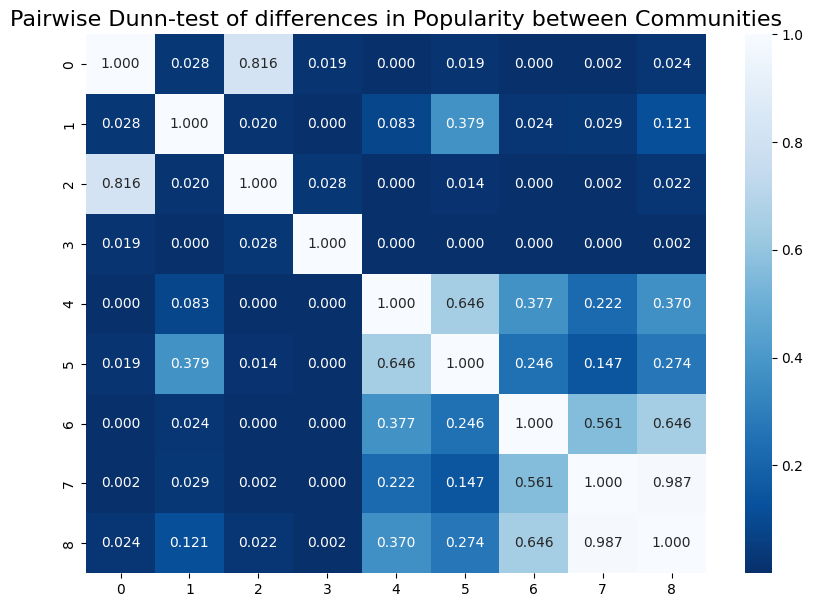

In [190]:
plt.figure(figsize=(10, 7))
sns.heatmap(pairwise, annot=True, cmap='Blues_r', fmt='.3f')
plt.title('Pairwise Dunn-test of differences in Popularity between Communities', fontsize=16)

## Community and Genre

In [ ]:
groups = [group['genre'].dropna().values for _, group in df.groupby('community') if len(group)>=5]
stat, pval = kruskal(*groups)
stat, pval

(np.float64(23.12946128868979), np.float64(0.0032019490937876443))

### D-matrix

In [130]:
genre_dict = {}
n_comm = np.max(df['community']) + 1

for g in df['genre']:
    for genre in g:
        if genre not in genre_dict.keys():
            genre_dict[genre] = 1
        
        if genre in genre_dict.keys():
            genre_dict[genre] += 1


del genre_dict['nogenre']
sorted_genres = {k: v for k, v in sorted(genre_dict.items(), key=lambda item: item[1], reverse=True)}



In [195]:
top_genres = dict(list(sorted_genres.items())[:30])
D = np.zeros((len(top_genres), n_comm))


for g in top_genres.keys():
    for c in range(n_comm):
        for genre in df[df['community'] == c]['genre']:
            if g in genre:
                D[list(top_genres.keys()).index(g), c] += 1




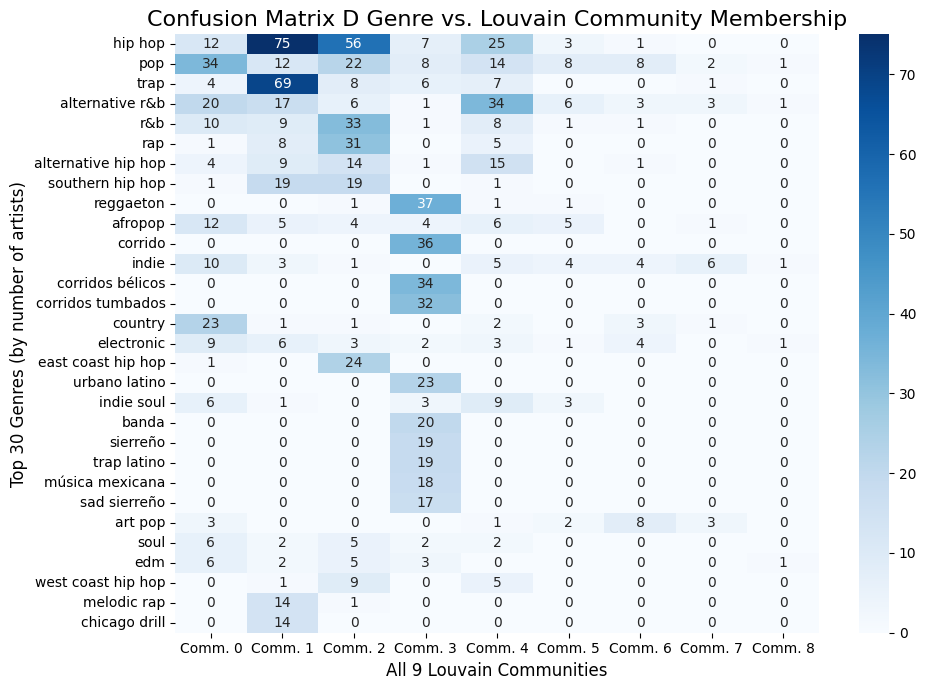

In [196]:
df_D = pd.DataFrame(D, index=list(top_genres.keys()), columns=[f'Comm. {i}' for i in range(n_comm)])
plt.figure(figsize=(10, 7))
sns.heatmap(df_D, annot=True, cmap='Blues', fmt='.0f')
plt.title('Confusion Matrix D Genre vs. Louvain Community Membership', fontsize=16)
plt.xlabel(f'All {n_comm} Louvain Communities', fontsize=12)
plt.ylabel(f'Top {len(top_genres)} Genres (by number of artists)', fontsize=12)
plt.tight_layout()
plt.show()